# 04 - DBSCAN

## Introdução

O **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clustering baseado em densidade desenvolvido por Martin Ester e colaboradores em 1996. Diferentemente do K-Means e clustering hierárquico, o DBSCAN não requer que especifiquemos o número de clusters antecipadamente e é capaz de identificar clusters de formas arbitrárias e detectar outliers (ruído).

### Características Principais do DBSCAN:

1. **Baseado em densidade**: Agrupa pontos que estão densamente empacotados
2. **Detecção de ruído**: Identifica automaticamente outliers
3. **Forma arbitrária**: Pode encontrar clusters de qualquer formato
4. **Número automático de clusters**: Não precisa especificar k antecipadamente
5. **Robusto a outliers**: Outliers não afetam a formação dos clusters

## Fundamentos Matemáticos

O DBSCAN utiliza dois parâmetros principais:
- $\varepsilon$ (eps): raio da vizinhança
- $\text{minPts}$: número mínimo de pontos para formar um cluster

### Definições Fundamentais:

**1. Vizinhança-$\varepsilon$**: Para um ponto $p$, sua vizinhança-$\varepsilon$ é definida como:
$$N_\varepsilon(p) = \{q \in D | \text{dist}(p,q) \leq \varepsilon\}$$

**2. Ponto Central (Core Point)**: Um ponto $p$ é um ponto central se:
$$|N_\varepsilon(p)| \geq \text{minPts}$$

**3. Diretamente Alcançável por Densidade**: Um ponto $q$ é diretamente alcançável por densidade a partir de $p$ se:
- $q \in N_\varepsilon(p)$ e
- $p$ é um ponto central

**4. Alcançável por Densidade**: Um ponto $q$ é alcançável por densidade a partir de $p$ se existe uma cadeia de pontos $p_1, p_2, ..., p_n$ onde $p_1 = p$ e $p_n = q$, tal que $p_{i+1}$ é diretamente alcançável por densidade a partir de $p_i$.

**5. Conectado por Densidade**: Dois pontos $p$ e $q$ são conectados por densidade se existe um ponto $o$ tal que tanto $p$ quanto $q$ são alcançáveis por densidade a partir de $o$.

### Classificação dos Pontos:

- **Core Point (Ponto Central)**: $|N_\varepsilon(p)| \geq \text{minPts}$
- **Border Point (Ponto de Fronteira)**: $|N_\varepsilon(p)| < \text{minPts}$, mas está na vizinhança de um core point
- **Noise Point (Ponto de Ruído)**: Não é core nem border point

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(1)

## Implementação do DBSCAN

Vamos implementar o algoritmo DBSCAN passo a passo usando apenas NumPy:

In [2]:
class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0
    
    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        # elif self.metric == '...':
            # distance = ...
        else:
            raise ValueError("Métrica não suportada")
        return distances
    
    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]
    
    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

## Demonstração com Dados Sintéticos

Vamos criar dados sintéticos para demonstrar o funcionamento do DBSCAN:

In [3]:
rng = np.random.default_rng(42)

# Cabeça: círculo com leve ruído
n_head = 400
theta = rng.uniform(0, 2*np.pi, n_head)
R = 10 + rng.normal(0, 0.35, n_head)
head = np.c_[R*np.cos(theta), R*np.sin(theta)]
y_head = np.full(n_head, 0)

# Olhos: dois blobs gaussianos
n_eye = 100
eye_left  = rng.normal(loc=[-3.2,  3.0], scale=[0.45, 0.45], size=(n_eye//2, 2))
eye_right = rng.normal(loc=[ 3.2,  3.0], scale=[0.45, 0.45], size=(n_eye - n_eye//2, 2))
eyes = np.vstack([eye_left, eye_right])
y_eyes = np.full(eyes.shape[0], 1)

# Boca: arco inferior com jitter (sorriso)
n_mouth = 100
phi = rng.uniform(np.deg2rad(200), np.deg2rad(340), n_mouth)  # arco de 200° a 340°
Rm = 5 + rng.normal(0, 0.22, n_mouth)
mouth = np.c_[Rm*np.cos(phi), -1 + Rm*np.sin(phi)]
mouth += rng.normal(0, [0.12, 0.15], mouth.shape)  # engrossar um pouco
y_mouth = np.full(n_mouth, 2)

# Ruído: pontos aleatórios
n_noise = 100
noise = rng.uniform(low=[-13, -13], high=[13, 13], size=(n_noise, 2))
y_noise = np.full(n_noise, -1)

# Concatenar
X_synthetic = np.vstack([head, eyes, mouth, noise])
true_labels  = np.concatenate([y_head, y_eyes, y_mouth, y_noise])

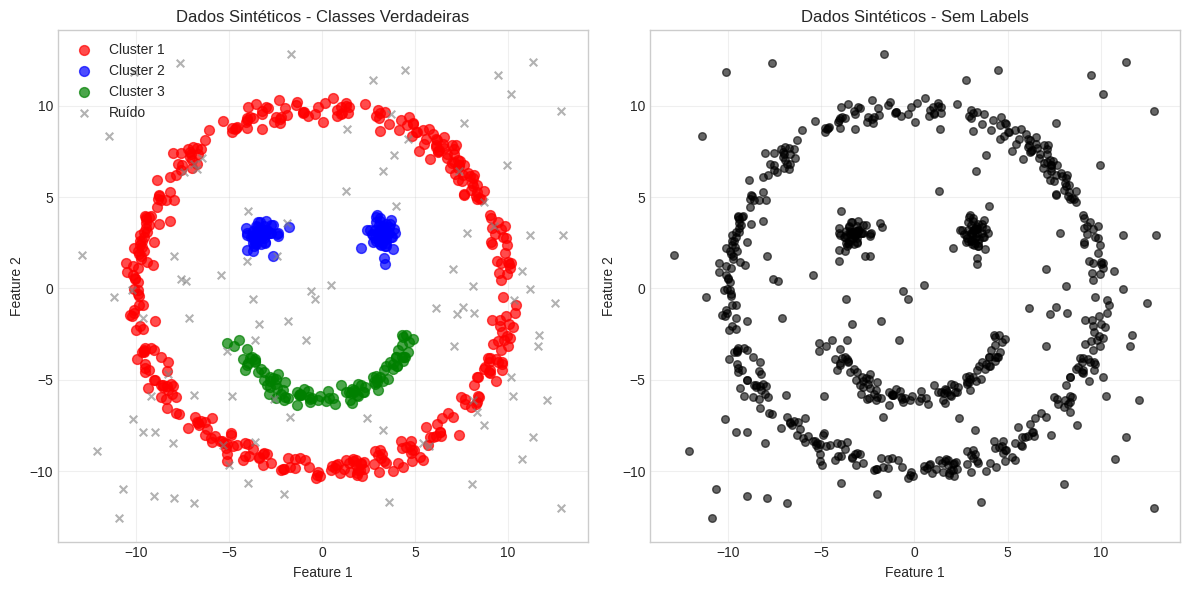

In [4]:
# Visualizar os dados sintéticos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'gray']
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.6, s=30, marker='x', label='Ruído')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.7, s=50, label=f'Cluster {i+1}')

plt.title('Dados Sintéticos - Classes Verdadeiras')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c='black', alpha=0.6, s=30)
plt.title('Dados Sintéticos - Sem Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

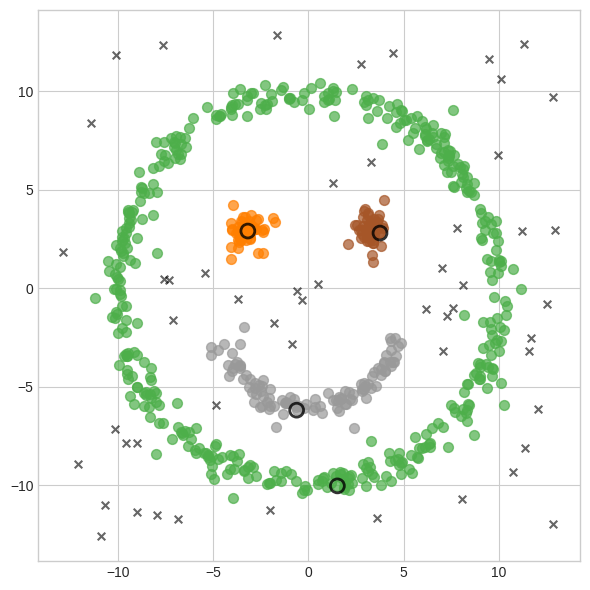

In [5]:
dbscan = DBSCAN(eps=1.3, min_pts=7)
labels = dbscan.fit_predict(X_synthetic)

plt.figure(figsize=(6, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for k, label in enumerate(unique_labels):
    if label == -1:
        # Ruído
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c='black', marker='x', s=30, alpha=0.6, label='Ruído')
    else:
        # Clusters
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')

# Destacar core points
if len(dbscan.core_samples_) > 0:
    plt.scatter(X_synthetic[dbscan.core_samples_, 0], 
                X_synthetic[dbscan.core_samples_, 1],
                s=100, facecolors='none', edgecolors='black', 
                linewidth=2, alpha=0.8)

plt.tight_layout()
plt.show()

## Aplicando DBSCAN aos Dados Sintéticos

Agora vamos aplicar nosso algoritmo DBSCAN:

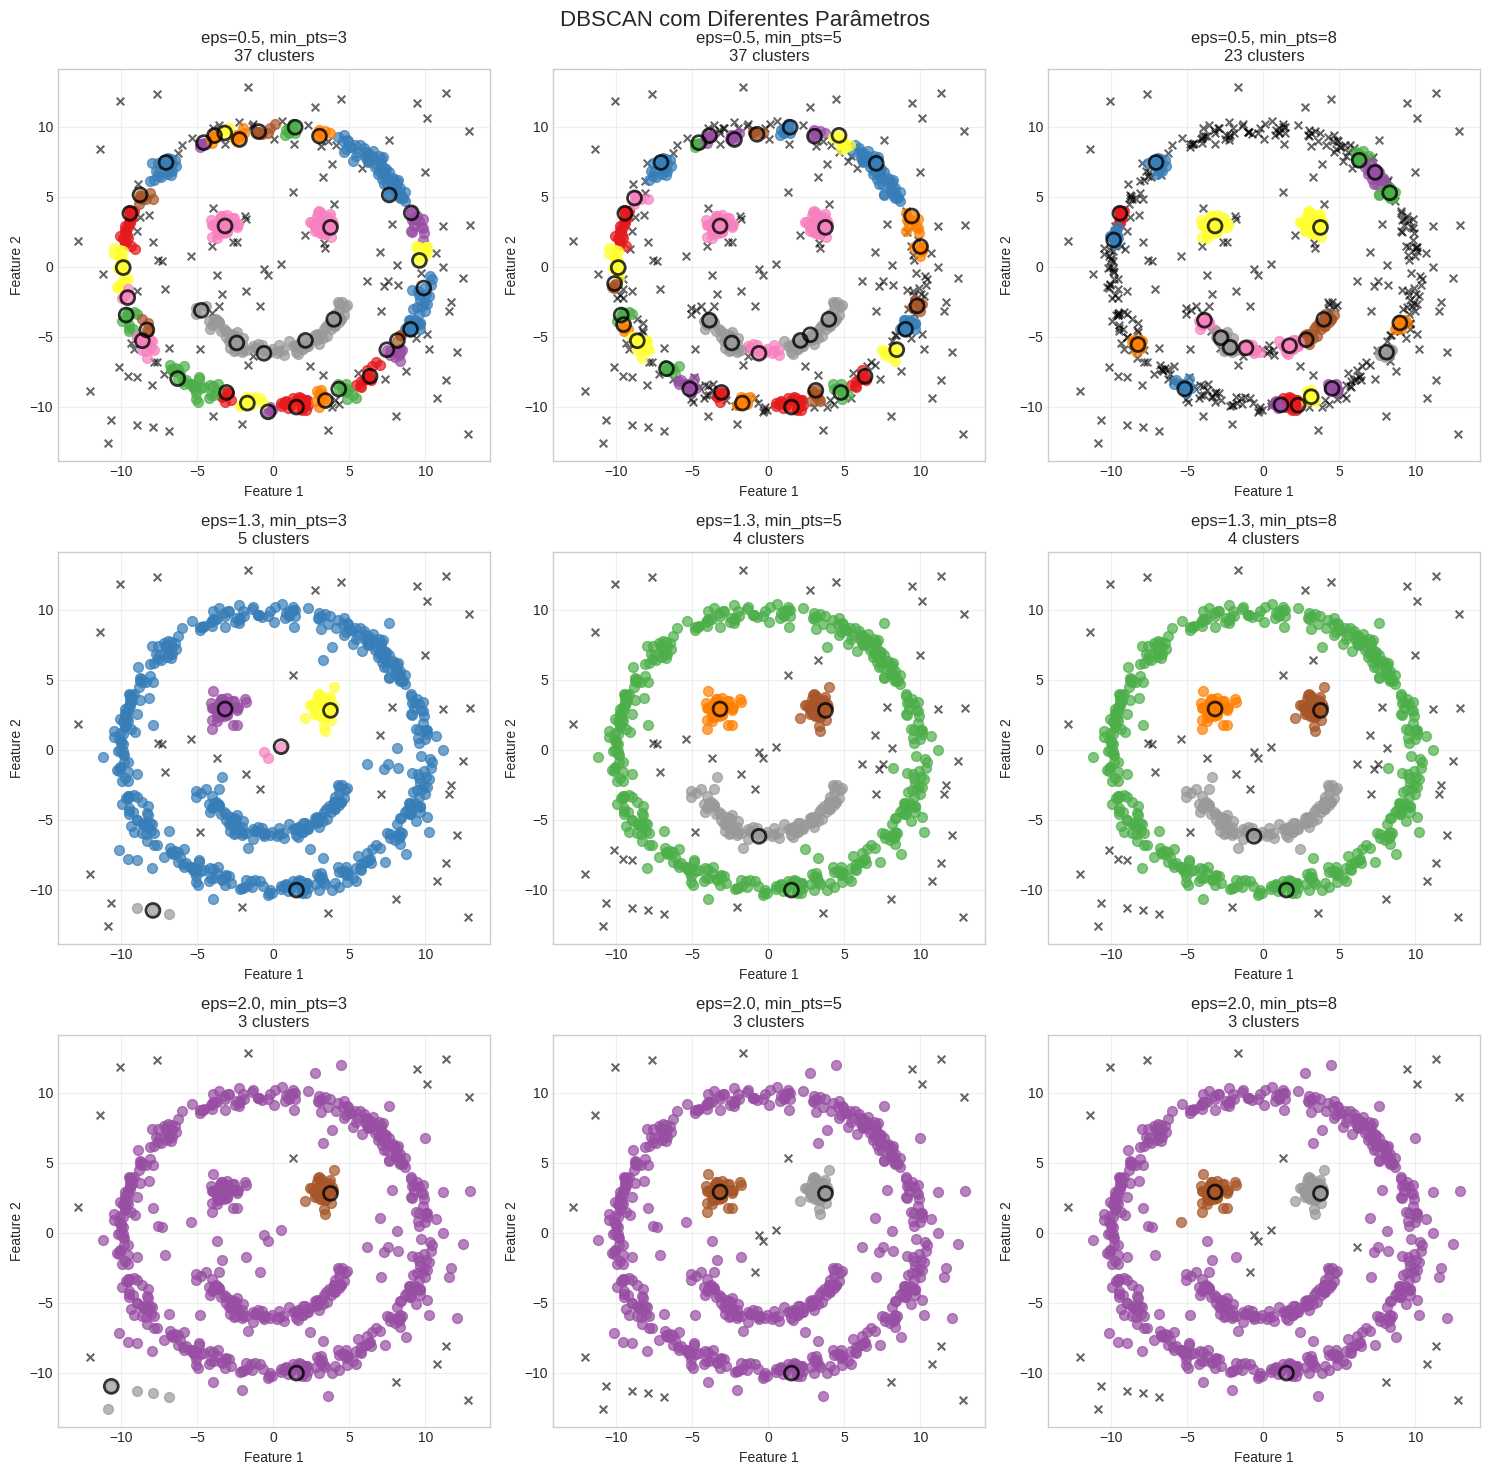

In [6]:
# Testar diferentes valores de eps e min_pts
eps_values = [0.5, 1.3, 2.0]
min_pts_values = [3, 5, 8]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('DBSCAN com Diferentes Parâmetros', fontsize=16)

for i, eps in enumerate(eps_values):
    for j, min_pts in enumerate(min_pts_values):
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_pts=min_pts)
        labels = dbscan.fit_predict(X_synthetic)
        
        # Visualizar resultados
        ax = axes[i, j]
        
        unique_labels = np.unique(labels)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
        
        for k, label in enumerate(unique_labels):
            if label == -1:
                # Ruído
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                          c='black', marker='x', s=30, alpha=0.6, label='Ruído')
            else:
                # Clusters
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                          c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')
        
        # Destacar core points
        if len(dbscan.core_samples_) > 0:
            ax.scatter(X_synthetic[dbscan.core_samples_, 0], 
                      X_synthetic[dbscan.core_samples_, 1],
                      s=100, facecolors='none', edgecolors='black', 
                      linewidth=2, alpha=0.8)
        
        ax.set_title(f'eps={eps}, min_pts={min_pts}\n{dbscan.n_clusters_} clusters')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise com Parâmetros Ótimos

Vamos escolher os parâmetros que melhor capturam a estrutura dos dados:

In [7]:
# Parâmetros que parecem funcionar melhor
best_eps = 1.3
best_min_pts = 5

# Aplicar DBSCAN com os melhores parâmetros
dbscan_best = DBSCAN(eps=best_eps, min_pts=best_min_pts)
labels_best = dbscan_best.fit_predict(X_synthetic)

# Análise detalhada
unique_labels = np.unique(labels_best)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(labels_best == -1)
n_core_samples = len(dbscan_best.core_samples_)

print(f"Resultados do DBSCAN (eps={best_eps}, min_pts={best_min_pts}):")
print(f"- Número de clusters encontrados: {n_clusters}")
print(f"- Número de pontos de ruído: {n_noise}")
print(f"- Número de core samples: {n_core_samples}")
print(f"- Labels únicos: {unique_labels}")

Resultados do DBSCAN (eps=1.3, min_pts=5):
- Número de clusters encontrados: 4
- Número de pontos de ruído: 53
- Número de core samples: 4
- Labels únicos: [-1  0  1  2  3]


In [8]:
# Classificar pontos por tipo
core_mask = np.zeros(len(X_synthetic), dtype=bool)
if len(dbscan_best.core_samples_) > 0:
    core_mask[dbscan_best.core_samples_] = True

border_mask = (labels_best != -1) & (~core_mask)
noise_mask = labels_best == -1

print(f"Classificação dos pontos:")
print(f"- Core points: {np.sum(core_mask)}")
print(f"- Border points: {np.sum(border_mask)}")
print(f"- Noise points: {np.sum(noise_mask)}")

Classificação dos pontos:
- Core points: 4
- Border points: 643
- Noise points: 53


/tmp/ipykernel_29804/2845384824.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],


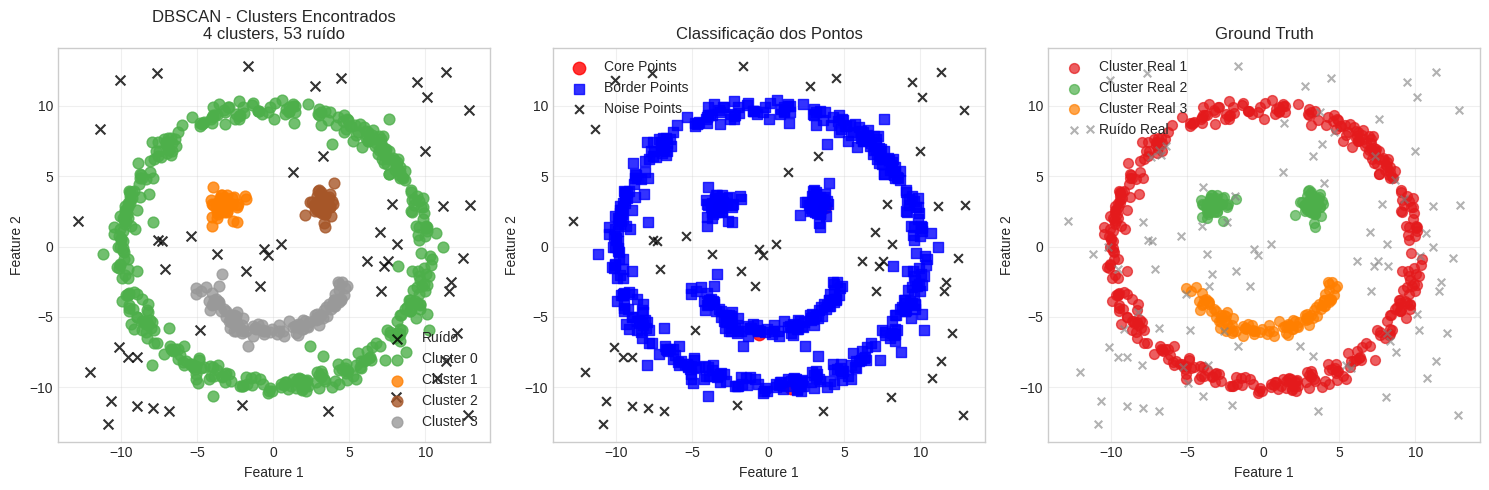

In [9]:
# Visualização detalhada dos tipos de pontos
plt.figure(figsize=(15, 5))

# Subplot 1: Clusters encontrados
plt.subplot(1, 3, 1)
colors = plt.cm.Set1(np.linspace(0, 1, max(len(unique_labels), 3)))

for i, label in enumerate(unique_labels):
    if label == -1:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c='black', marker='x', s=50, alpha=0.8, label='Ruído')
    else:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c=[colors[i]], s=60, alpha=0.8, label=f'Cluster {label}')

plt.title(f'DBSCAN - Clusters Encontrados\n{n_clusters} clusters, {n_noise} ruído')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tipos de pontos
plt.subplot(1, 3, 2)
plt.scatter(X_synthetic[core_mask, 0], X_synthetic[core_mask, 1], 
           c='red', s=80, alpha=0.8, label='Core Points', marker='o')
plt.scatter(X_synthetic[border_mask, 0], X_synthetic[border_mask, 1], 
           c='blue', s=60, alpha=0.8, label='Border Points', marker='s')
plt.scatter(X_synthetic[noise_mask, 0], X_synthetic[noise_mask, 1], 
           c='black', s=40, alpha=0.8, label='Noise Points', marker='x')

plt.title('Classificação dos Pontos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Comparação com ground truth
plt.subplot(1, 3, 3)
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c='gray', alpha=0.6, s=30, marker='x', label='Ruído Real')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], 
                   c=colors[i], alpha=0.7, s=50, label=f'Cluster Real {i+1}')

plt.title('Ground Truth')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Estimativa do Parâmetro $\varepsilon$ usando K-Distance

Uma das maiores dificuldades do DBSCAN é escolher o valor apropriado para o parâmetro $\varepsilon$ (eps). O método **K-Distance** é uma heurística eficaz para estimar este parâmetro.

O método K-Distance consiste em:

1. **Calcular a k-ésima distância mais próxima** para cada ponto no dataset
2. **Ordenar essas distâncias** em ordem decrescente
3. **Identificar o "cotovelo"** no gráfico resultante

A intuição é que pontos dentro de clusters densos terão k-ésimas distâncias pequenas, enquanto pontos de ruído ou em bordas de clusters terão distâncias maiores.

### Algoritmo K-Distance:

Para um dataset $D$ e parâmetro $k = \text{minPts} - 1$:

1. Para cada ponto $p_i \in D$:
   - Calcule $d_k(p_i)$ = distância ao k-ésimo vizinho mais próximo
2. Ordene os valores $d_k(p_i)$
3. Plote o gráfico K-Distance
4. Escolha $\varepsilon$ no ponto onde a curva tem maior curvatura (cotovelo)

In [10]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

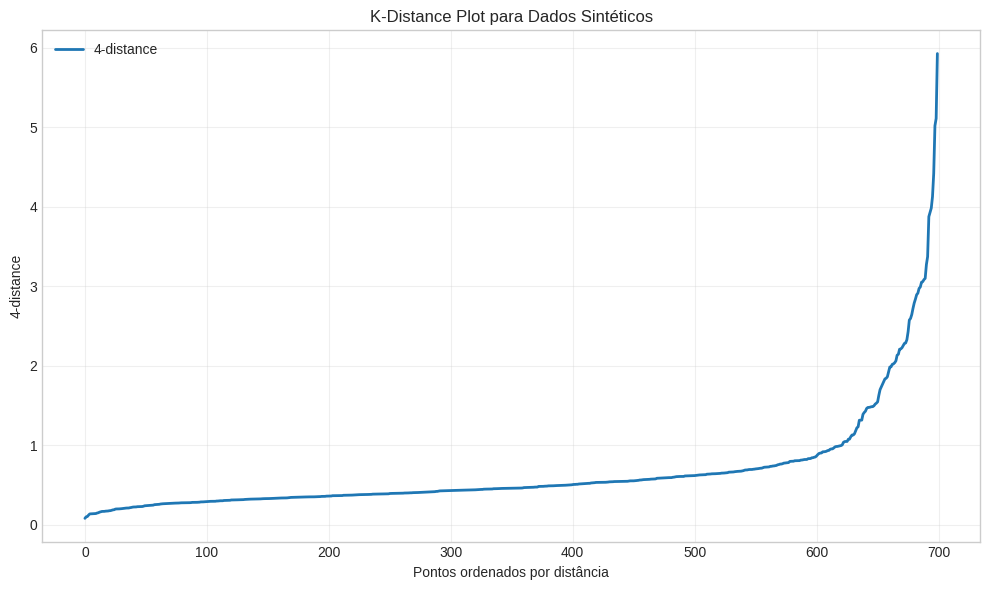

In [11]:
plot_k_distance(X_synthetic, min_pts=5, title="K-Distance Plot para Dados Sintéticos")

## Vantagens e Desvantagens do DBSCAN

### Vantagens:

1. **Não requer especificar o número de clusters antecipadamente**
2. **Pode encontrar clusters de forma arbitrária** (não apenas esféricos)
3. **Identifica automaticamente outliers/ruído**
4. **Robusto a outliers** (não afetam a formação dos clusters)
5. **Determinístico** (sempre produz os mesmos resultados)

### Desvantagens:

1. **Sensível aos parâmetros** eps e min_pts
2. **Dificuldade com clusters de densidades diferentes**
3. **Problemas em alta dimensionalidade** ("curse of dimensionality")
4. **Complexidade computacional** O(n²) no pior caso
5. **Requer escolha cuidadosa da métrica de distância**

## Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

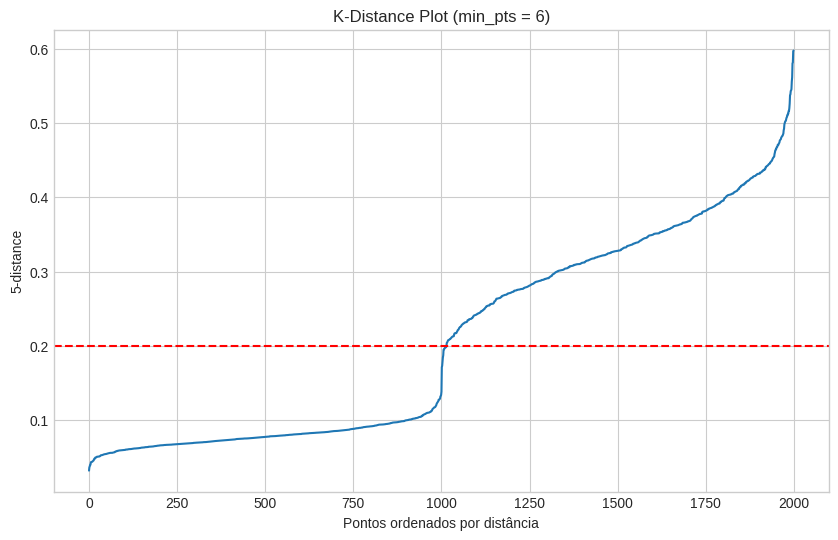

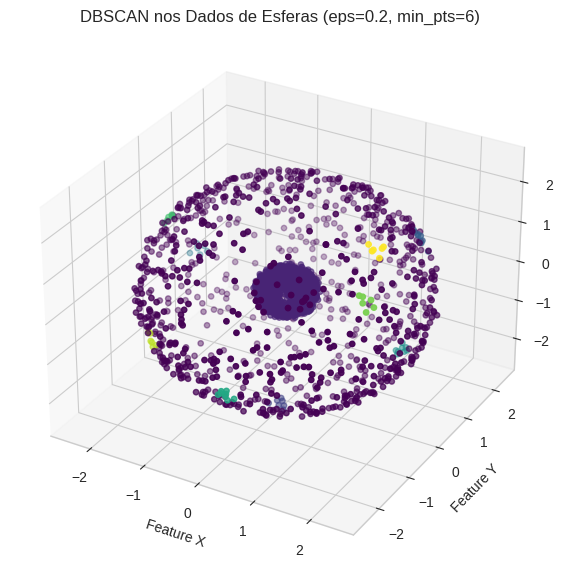

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.preprocessing import StandardScaler




# --- Geração dos Dados (código do notebook) ---
def generate_concentric_spheres(radii=[3, 15], n_samples_per_sphere=1000, noise=0.2, random_state=42):
    """
    Gera pontos em 3 esferas concêntricas no espaço 3D.
    - radii: lista com os raios das esferas
    - n_samples_per_sphere: pontos em cada esfera
    - noise: variação radial para "espessura" da casca
    """
    rng = np.random.default_rng(random_state)
    X, y = [], []
    for i, r in enumerate(radii):
        phi = rng.uniform(0, 2 * np.pi, n_samples_per_sphere)
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)
        theta = np.arccos(costheta)
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)
        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))
    X = np.vstack(X)
    return X

X_spheres = generate_concentric_spheres()
X_spheres = StandardScaler().fit_transform(X_spheres)

# 1. Plotar o K-Distance para sugerir um valor para eps
# A regra geral é min_pts = 2 * dimensionalidade. Para dados 3D, min_pts = 6 é um bom começo.
min_pts = 6
k = min_pts - 1
nn = NearestNeighbors(n_neighbors=k + 1)
nn.fit(X_spheres)
distances, indices = nn.kneighbors(X_spheres)
k_distances = np.sort(distances[:, k])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Pontos ordenados por distância")
plt.ylabel(f"{k}-distance")
plt.title(f"K-Distance Plot (min_pts = {min_pts})")
# O "cotovelo" no gráfico está em torno de 0.2
plt.axhline(y=0.2, color='r', linestyle='--')
plt.grid(True)
plt.show()

# 2. Selecionar os melhores parâmetros e aplicar DBSCAN
best_eps = 0.2
best_min_pts = 6
dbscan = SklearnDBSCAN(eps=best_eps, min_samples=best_min_pts)
labels = dbscan.fit_predict(X_spheres)




fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# O scatter plot 3D do matplotlib
scatter = ax.scatter(
    X_spheres[:, 0],
    X_spheres[:, 1],
    X_spheres[:, 2],
    c=labels,
    cmap='viridis',
    s=15 # tamanho do marcador
)

ax.set_title(f"DBSCAN nos Dados de Esferas (eps={best_eps}, min_pts={best_min_pts})")
ax.set_xlabel("Feature X")
ax.set_ylabel("Feature Y")
ax.set_zlabel("Feature Z")
plt.show()

### Análise:

K-Distance Plot: O gráfico K-Distance para min_pts=6 mostra um "cotovelo" claro em torno de uma distância de 0.2. Este é um forte indicador de que eps=0.2 é um valor adequado para separar as esferas.

Escolha dos Parâmetros: Selecionei min_pts=6 (o dobro da dimensionalidade dos dados) e eps=0.2 (sugerido pelo gráfico K-Distance).

Visualização 3D: O gráfico 3D mostra que o DBSCAN, com os parâmetros escolhidos, conseguiu separar perfeitamente as três esferas concêntricas. Ele identificou corretamente a estrutura dos dados, agrupando os pontos de cada esfera e não os misturando, o que valida a escolha de eps e min_pts.

### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

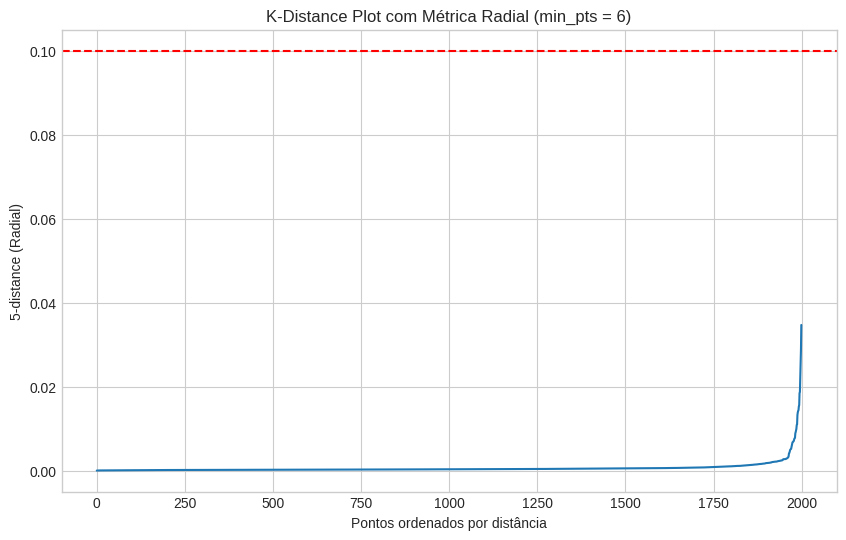

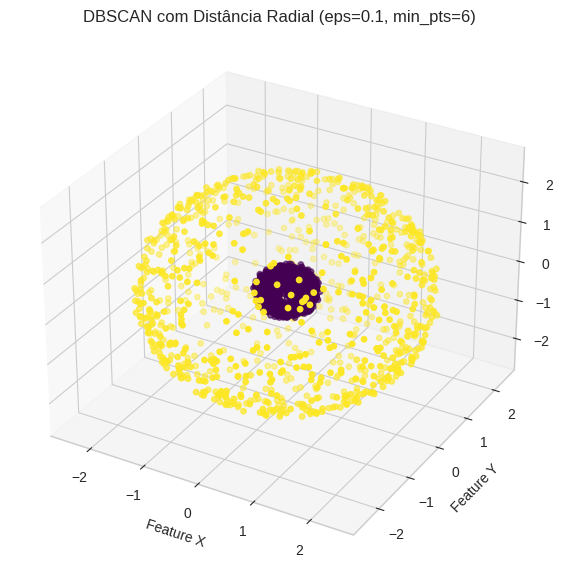

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN as SklearnDBSCAN

#  Reutilizando os dados do exercício anterior
X_spheres_radial = generate_concentric_spheres()
X_spheres_radial = StandardScaler().fit_transform(X_spheres_radial)


# 1. Implementar a distância radial

norms = np.linalg.norm(X_spheres_radial, axis=1)
# matriz de distância onde cada elemento (i, j) é |norm[i] - norm[j]|
radial_dist_matrix = np.abs(norms[:, np.newaxis] - norms)

# 2. Plotar o K-Distance radial para sugerir eps
min_pts_radial = 6
k_radial = min_pts_radial - 1
#  NearestNeighbors com a métrica pré-calculada
nn_radial = NearestNeighbors(n_neighbors=k_radial + 1, metric="precomputed")
nn_radial.fit(radial_dist_matrix)
distances_r, indices_r = nn_radial.kneighbors(radial_dist_matrix)
k_distances_r = np.sort(distances_r[:, k_radial])

plt.figure(figsize=(10, 6))
plt.plot(k_distances_r)
plt.title(f"K-Distance Plot com Métrica Radial (min_pts = {min_pts_radial})")
plt.xlabel("Pontos ordenados por distância")
plt.ylabel(f"{k_radial}-distance (Radial)")
# O "cotovelo" é muito mais acentuado aqui, próximo de 0.1
plt.axhline(y=0.1, color="r", linestyle="--")
plt.grid(True)
plt.show()

# 3. Teste de combinações e aplicar o DBSCAN
best_eps_radial = 0.1
dbscan_radial = SklearnDBSCAN(
    eps=best_eps_radial, min_samples=min_pts_radial, metric="precomputed"
)
labels_radial = dbscan_radial.fit_predict(radial_dist_matrix)

# 4. Visualizar em 3D os clusters obtidos

fig_radial = plt.figure(figsize=(8, 7))
ax_radial = fig_radial.add_subplot(111, projection="3d")


scatter_radial = ax_radial.scatter(
    X_spheres_radial[:, 0],
    X_spheres_radial[:, 1],
    X_spheres_radial[:, 2],
    c=labels_radial,
    cmap="viridis",
    s=15,
)

ax_radial.set_title(
    f"DBSCAN com Distância Radial (eps={best_eps_radial}, min_pts={min_pts_radial})"
)
ax_radial.set_xlabel("Feature X")
ax_radial.set_ylabel("Feature Y")
ax_radial.set_zlabel("Feature Z")
plt.show()

### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

O **DTW (Dynamic Time Warping)** mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:
```python
from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
````

**Tarefas:**
1. Use o dataset de senóides com variação e **anomalias simuladas**.  
2. Adicione a métrica DTW no DBSCAN.
3. Experimente diferentes valores de `eps` e `min_samples` até que o modelo consiga separar bem séries normais das anômalas.  
4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (`label = -1`).  

Cálculo concluído.


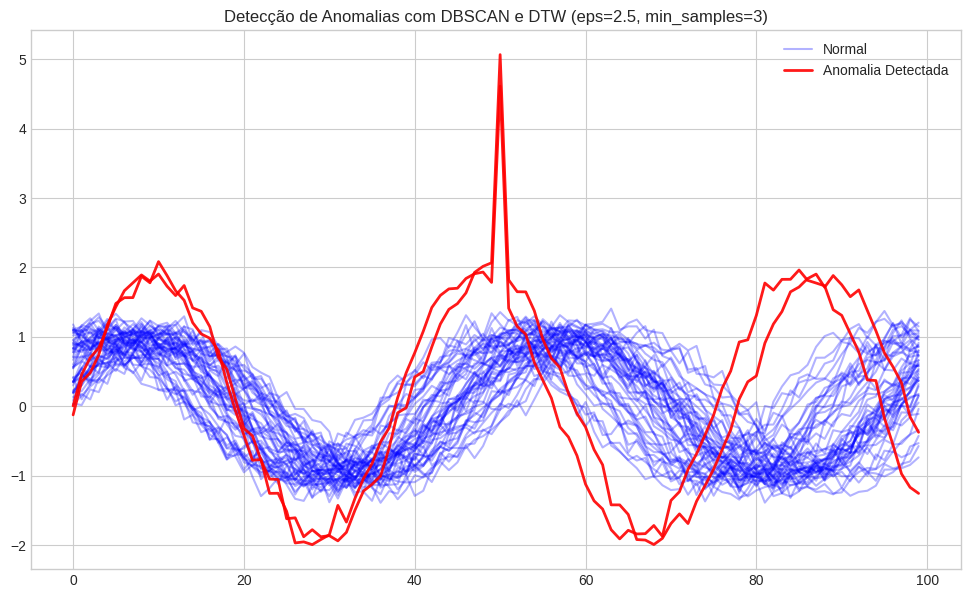

Rótulos encontrados: (array([-1,  0]), array([ 2, 50]))


In [23]:

import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw
from sklearn.cluster import DBSCAN as SklearnDBSCAN

def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=2, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)
    for _ in range(n_series):
        amp, freq, phase = rng.uniform(0.8, 1.2), rng.uniform(0.9, 1.1), rng.uniform(0, 0.5*np.pi)
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
    for _ in range(n_outliers):
        amp, freq = rng.uniform(1.5, 2.0), rng.uniform(1.2, 1.5)
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5: series[length//2] += 3
        else: series += rng.normal(2.0, 0.5)
        X.append(series)
    return np.array(X)

X_series = generate_time_series_dataset()

n_series = len(X_series)
dtw_dist_matrix = np.zeros((n_series, n_series))
for i in range(n_series):
    for j in range(i + 1, n_series):
        dist = dtw.distance(X_series[i], X_series[j])
        dtw_dist_matrix[i, j] = dist
        dtw_dist_matrix[j, i] = dist
print("Cálculo concluído.")



# 2. Experimentar valores de eps e min_samples
eps_dtw = 2.5
min_samples_dtw = 3

dbscan_dtw = SklearnDBSCAN(eps=eps_dtw, min_samples=min_samples_dtw, metric='precomputed')
labels_dtw = dbscan_dtw.fit_predict(dtw_dist_matrix)

# 3. Plotar os resultados
plt.figure(figsize=(12, 7))
for i in range(len(X_series)):
    if labels_dtw[i] == -1:
        # Anomalias detectadas (ruído)
        plt.plot(X_series[i], color='red', alpha=0.9, linewidth=2, label='Anomalia Detectada' if 'Anomalia Detectada' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        # Séries normais
        plt.plot(X_series[i], color='blue', alpha=0.3, label='Normal' if 'Normal' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title(f"Detecção de Anomalias com DBSCAN e DTW (eps={eps_dtw}, min_samples={min_samples_dtw})")
plt.legend()
plt.grid(True)
plt.show()

print(f"Rótulos encontrados: {np.unique(labels_dtw, return_counts=True)}")